In [63]:
from langchain import OpenAI
from langchain.agents import Tool, tool
from langchain import agents
import langchain
import os
import warnings
import numpy as np
warnings.filterwarnings('ignore')
import sys
import dziner


# from langchain.chains import RetrievalQA
from langchain.document_loaders import PyPDFLoader
from langchain_openai import ChatOpenAI

from langchain.vectorstores import FAISS
from langchain.embeddings.openai import OpenAIEmbeddings
Embedding_model = 'text-embedding-3-large' 

from langchain.text_splitter import CharacterTextSplitter

In [64]:
## This model based on this paper: https://pubs.acs.org/doi/abs/10.1021/acs.jpcb.1c05264
## And is coming from this URL 
## https://github.com/zavalab/ML/blob/master/CMC_GCN/saved_models/gnn_logs_save_202_hu256_lr0.005_best_trainalles_seed4592/ep200bs5lr0.005hu256es.pth.tar

import torch
from dziner.surrogates.CMC.model import predict_single_point

@tool
def predict_cmc(smiles):
    '''
    This tool predicts the mean log Critical Micelle Concentration (LogCMC) and it standard deviation for a SMILES.
    The model is based on a GCN from this paper:
    https://pubs.acs.org/doi/abs/10.1021/acs.jpcb.1c05264
    '''
    base_model_path = "../dziner/surrogates/CMC/training/11-folds/ep200bs5lr0.005kf11hu256cvid{}.pth.tar"
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    predictions = []

    # Looping through the ensemble of models with 11-fold cross validation.
    for cvid in range(11):  
        model_path = base_model_path.format(cvid)
        try:
            prediction = predict_single_point(smiles, model_path, device)
            predictions.append(prediction)
        except:
            predictions.append(None)
    
    valid_predictions = [p for p in predictions if p is not None]
    
    if not valid_predictions:
        return 'Invalid molecule', None
    
    mean_prediction = np.mean(valid_predictions)
    std_prediction = np.std(valid_predictions)
    
    return np.round(mean_prediction, 3), np.round(std_prediction, 3)

# Example usage
smiles = 'CCCCCOCCO'
mean_cmc, std_cmc = predict_cmc(smiles)
print(f"Mean CMC: {mean_cmc}, Std CMC: {std_cmc}")

Mean CMC: 4.399, Std CMC: 0.223


In [65]:
from langchain.memory import ConversationBufferMemory

RetrievalQA_prompt = """What are the design guidelines for making the surfactant with a Critical Micelle Concentration? 
    This can be based on making changes to the functional groups or other changes to the molecule. Summarize your answer and cite paper
    by the title, DOI and the journal and year the document was published on."""

@tool
def lookup_papers(prompt):
    '''Useful for getting chemical intuition for the problem.
    This tool looks up design guidelines for molecules with lower Critical Micelle Concentration by looking through research papers.
    It also includes information on the paper citation or DOI.
    '''
    guide_lines = []
    for m in range(6):
        text_splitter = CharacterTextSplitter(
            chunk_size=500, chunk_overlap=20)
        paper_file =f'../data/papers/CMC/{m}.pdf'
        pages = PyPDFLoader(paper_file).load_and_split()
        sliced_pages = text_splitter.split_documents(pages)
        faiss_vectorstore = FAISS.from_documents(sliced_pages, OpenAIEmbeddings(model=Embedding_model))
        
        llm=ChatOpenAI(
                        model_name='gpt-4o',
                        temperature=0.1,
                        )
        g = dziner.RetrievalQABypassTokenLimit(faiss_vectorstore, RetrievalQA_prompt, llm)
        guide_lines.append(g)
        # break
    return " ".join(guide_lines)

# guidel_lines = lookup_papers("")
# guidel_lines

In [60]:

@tool
def check_validity(SMILES):
    '''This tool inputs SMILES string representations checks if it is a chemically feasible molecule.
    '''
    from rdkit import Chem
    from rdkit.Chem import Draw
    try:
        mol = Chem.MolFromSmiles(SMILES)
        if mol is None:
            return "Invalid", SMILES
        return "Valid", SMILES
    except Exception as e:
        # return f"An error occurred: {str(e)}"
        return "Invalid ", SMILES

tools = [lookup_papers, check_validity, predict_cmc]

tool_names = [tool.name for tool in tools]  
tool_desc = [tool.description for tool in tools]

initial_surfactant = "CCCCCCCCCC(=O)CC(=O)NC1CCOC1=O" 
Human_prompt = f"Make changes to {initial_surfactant} so it will have a lower Critical Micelle Concentration (CMC)"

input_data = {
            "input": Human_prompt,
            "prompt": RetrievalQA_prompt,
            "tools": tools,
            "tool_names": tool_names,
            "tool_desc": tool_desc
        }

In [61]:
FORMAT_INSTRUCTIONS = """Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
When you have a response to say to the Human, or if you do not need to use a tool, you MUST use the format:
'''
Thought: Here's your final answer:
Final Answer: [your response here]
'''

Use the exact SMILES without any "\n" or any extra "()".
"""

suffix = """You should always follow these steps:
    1. Lookup and summarize design guidelines. Make sure to add citations (paper DOI) for design guidelines if you use them, in your final response.
    Your final response should also contain the source for the tools used from their summary in description in {tool_desc}.
    2. Evaluate the Critical Micelle Concentration (CMC) of the initial molecule.
    3. Evaluate the validity of the initial molecule.
    4. Start making changes to the molecule based on guidelines you found in step 1. Try to use different changes at each iteration.
    5. Evaluate the Critical Micelle Concentration (CMC) for the new molecule
    6. Evaluate validity of the SMILES for the new molecule
    7. If the Critical Micelle Concentration (CMC) does not change properly, still evaluate validity and if the
    molecule is invalid, revert change to the previous valid SMILES and try something else by
    redoing steps 4-7. Iterate until there are 10 new SMILES candidates and then stop.

    Start by describing the problem: \n\nBegin!\n \n\nQuestion: {input}
Thought:{agent_scratchpad}\n"""

In [64]:
# from dziner.agents import dZiner
agent = dZiner(tools, property="Critical Micelle Concentration (CMC)",
               model='gpt-4o', verbose=True, n_design_iterations=10, temp=0.2,
              suffix=suffix, prefix=prefix, format_instructions=FORMAT_INSTRUCTIONS).agent

agent.get_prompts

<bound method Runnable.get_prompts of AgentExecutor(memory=ConversationBufferMemory(output_key='output', input_key='input', return_messages=True, memory_key='chat_history'), verbose=True, tags=['zero-shot-react-description'], agent=ZeroShotAgent(llm_chain=LLMChain(prompt=PromptTemplate(input_variables=['agent_scratchpad', 'input', 'tool_desc'], template='You are a helpful Chemist AI assistant called dZiner. You are tasked to make changes to a molecule based on some design guidelines\n    and optimize the molecule\'s property.\n    Always use the tools to get chemical intuition learn about the design guidelines. If you don\'t know, do not make up answers.\n    Explain changes you make in details at each step but do not put redundant information.\n    \n\nlookup_papers(prompt) - Useful for getting chemical intuition for the problem.\n    This tool looks up design guidelines for molecules with lower Critical Micelle Concentration by looking through research papers.\n    It also includes i

In [65]:
# response = agent_executor.invoke({"input": f"Look up design guidelines and make changes to the MOF [Co].[O-]C(=O)c1ccncc1 so it will have a higher band gap:\
#             After each change you should first check validity of new SMILES, if valid evaluate the band gap, otherwise revert change and try something else.\n\
#             "})

In [66]:
# Initialize iteration variables
iteration_data = []
iteration = 0
cost = 0
from langchain_community.callbacks import get_openai_callback


for step in agent.iter(input_data):
    with get_openai_callback() as cb:
        if output := step.get("intermediate_step"):
            action, value = output[0]
            if action.tool == "predict_cmc":
                mean_cmc, std_cmc = value  # Capture the predicted CMC value and the error on prediction
            elif action.tool == "check_validity":
                current_feasibility, current_smiles = value
                current_smiles = current_smiles.strip()  # Remove any trailing newline characters
                iteration_data.append({
                        'iteration': iteration,
                        'data': {
                            'SMILES': current_smiles,
                            'Chemical Feasibility': current_feasibility,
                            'mean CMC': mean_cmc,
                            'std CMC': std_cmc
                            
                        }
                    })
                iteration += 1
        # elif step.get("Observation") == 'Invalid molecule':
        #     # Handle invalid molecule case
        #     iteration_data.append({
        #         'iteration': iteration,
        #         'data': {
        #             'SMILES': "Invalid",
        #             'Chemical Feasibility': "Invalid",
        #             'CMC': infered_cmc,
        #         }
        #     })
        #     iteration += 1
        # Ask user if they want to continue
        #             # _continue = input("Should the agent continue (Y/n)?:\n") or "Y"
        #             # if _continue.lower() != "y":
        #             #     break
    cost += cb.total_cost





> Entering new AgentExecutor chain...
First, I need to gather design guidelines for molecules with lower Critical Micelle Concentration (CMC) by looking through research papers.

Action: lookup_papers
Action Input: design guidelines for molecules with lower Critical Micelle Concentration
Observation: To design surfactants with an optimal Critical Micelle Concentration (cmc), several structural modifications can be considered:

1. **Hydrophobic Tail Structure**: The hydrophobic tail significantly influences the cmc. Increasing the length of the hydrocarbon chain generally decreases the cmc. However, branching the hydrocarbon chains, especially at the chain tips with low-surface-energy groups like methyl (CH3−), can also reduce the cmc by promoting dense surface packing and minimizing dipolar interactions.

2. **Headgroup Modifications**: The nature of the headgroup affects the solubility and surface activity of the surfactant. For instance, using headgroups that promote better water s

In [67]:
iteration_data

[{'iteration': 0,
  'data': {'SMILES': 'CCCCCCCCCC(=O)CC(=O)NC1CCOC1=O',
   'Chemical Feasibility': 'Valid',
   'mean CMC': 1.785,
   'std CMC': 0.321}},
 {'iteration': 1,
  'data': {'SMILES': 'CCCCCCCCCCCC(=O)CC(=O)NC1CCOC1=O',
   'Chemical Feasibility': 'Valid',
   'mean CMC': 1.785,
   'std CMC': 0.321}},
 {'iteration': 2,
  'data': {'SMILES': 'CCC(C)CCCCCCCC(=O)CC(=O)NC1CCOC1=O',
   'Chemical Feasibility': 'Valid',
   'mean CMC': 1.054,
   'std CMC': 0.268}},
 {'iteration': 3,
  'data': {'SMILES': 'CCCCCCCCCCCC(=O)CC(O)NC1CCOC1=O',
   'Chemical Feasibility': 'Valid',
   'mean CMC': 2.225,
   'std CMC': 0.369}},
 {'iteration': 4,
  'data': {'SMILES': 'CCCCCCCCCCC(F)(F)CC(=O)NC1CCOC1=O',
   'Chemical Feasibility': 'Valid',
   'mean CMC': 1.216,
   'std CMC': 0.474}},
 {'iteration': 5,
  'data': {'SMILES': 'CCCCCCCCCCC[Si](C)(C)CC(=O)NC1CCOC1=O',
   'Chemical Feasibility': 'Valid',
   'mean CMC': 0.767,
   'std CMC': 0.311}},
 {'iteration': 6,
  'data': {'SMILES': 'CCCCCCCCCCC1CCCCC1C

In [74]:
import json
json_data = json.dumps(iteration_data, indent=4)
# Save the JSON data to a file
with open(f"../results/CMC/{iteration_data[0]['data']['SMILES']}_guided.json", "w") as json_file:
    json_file.write(json_data)

<Figure size 2560x1920 with 0 Axes>

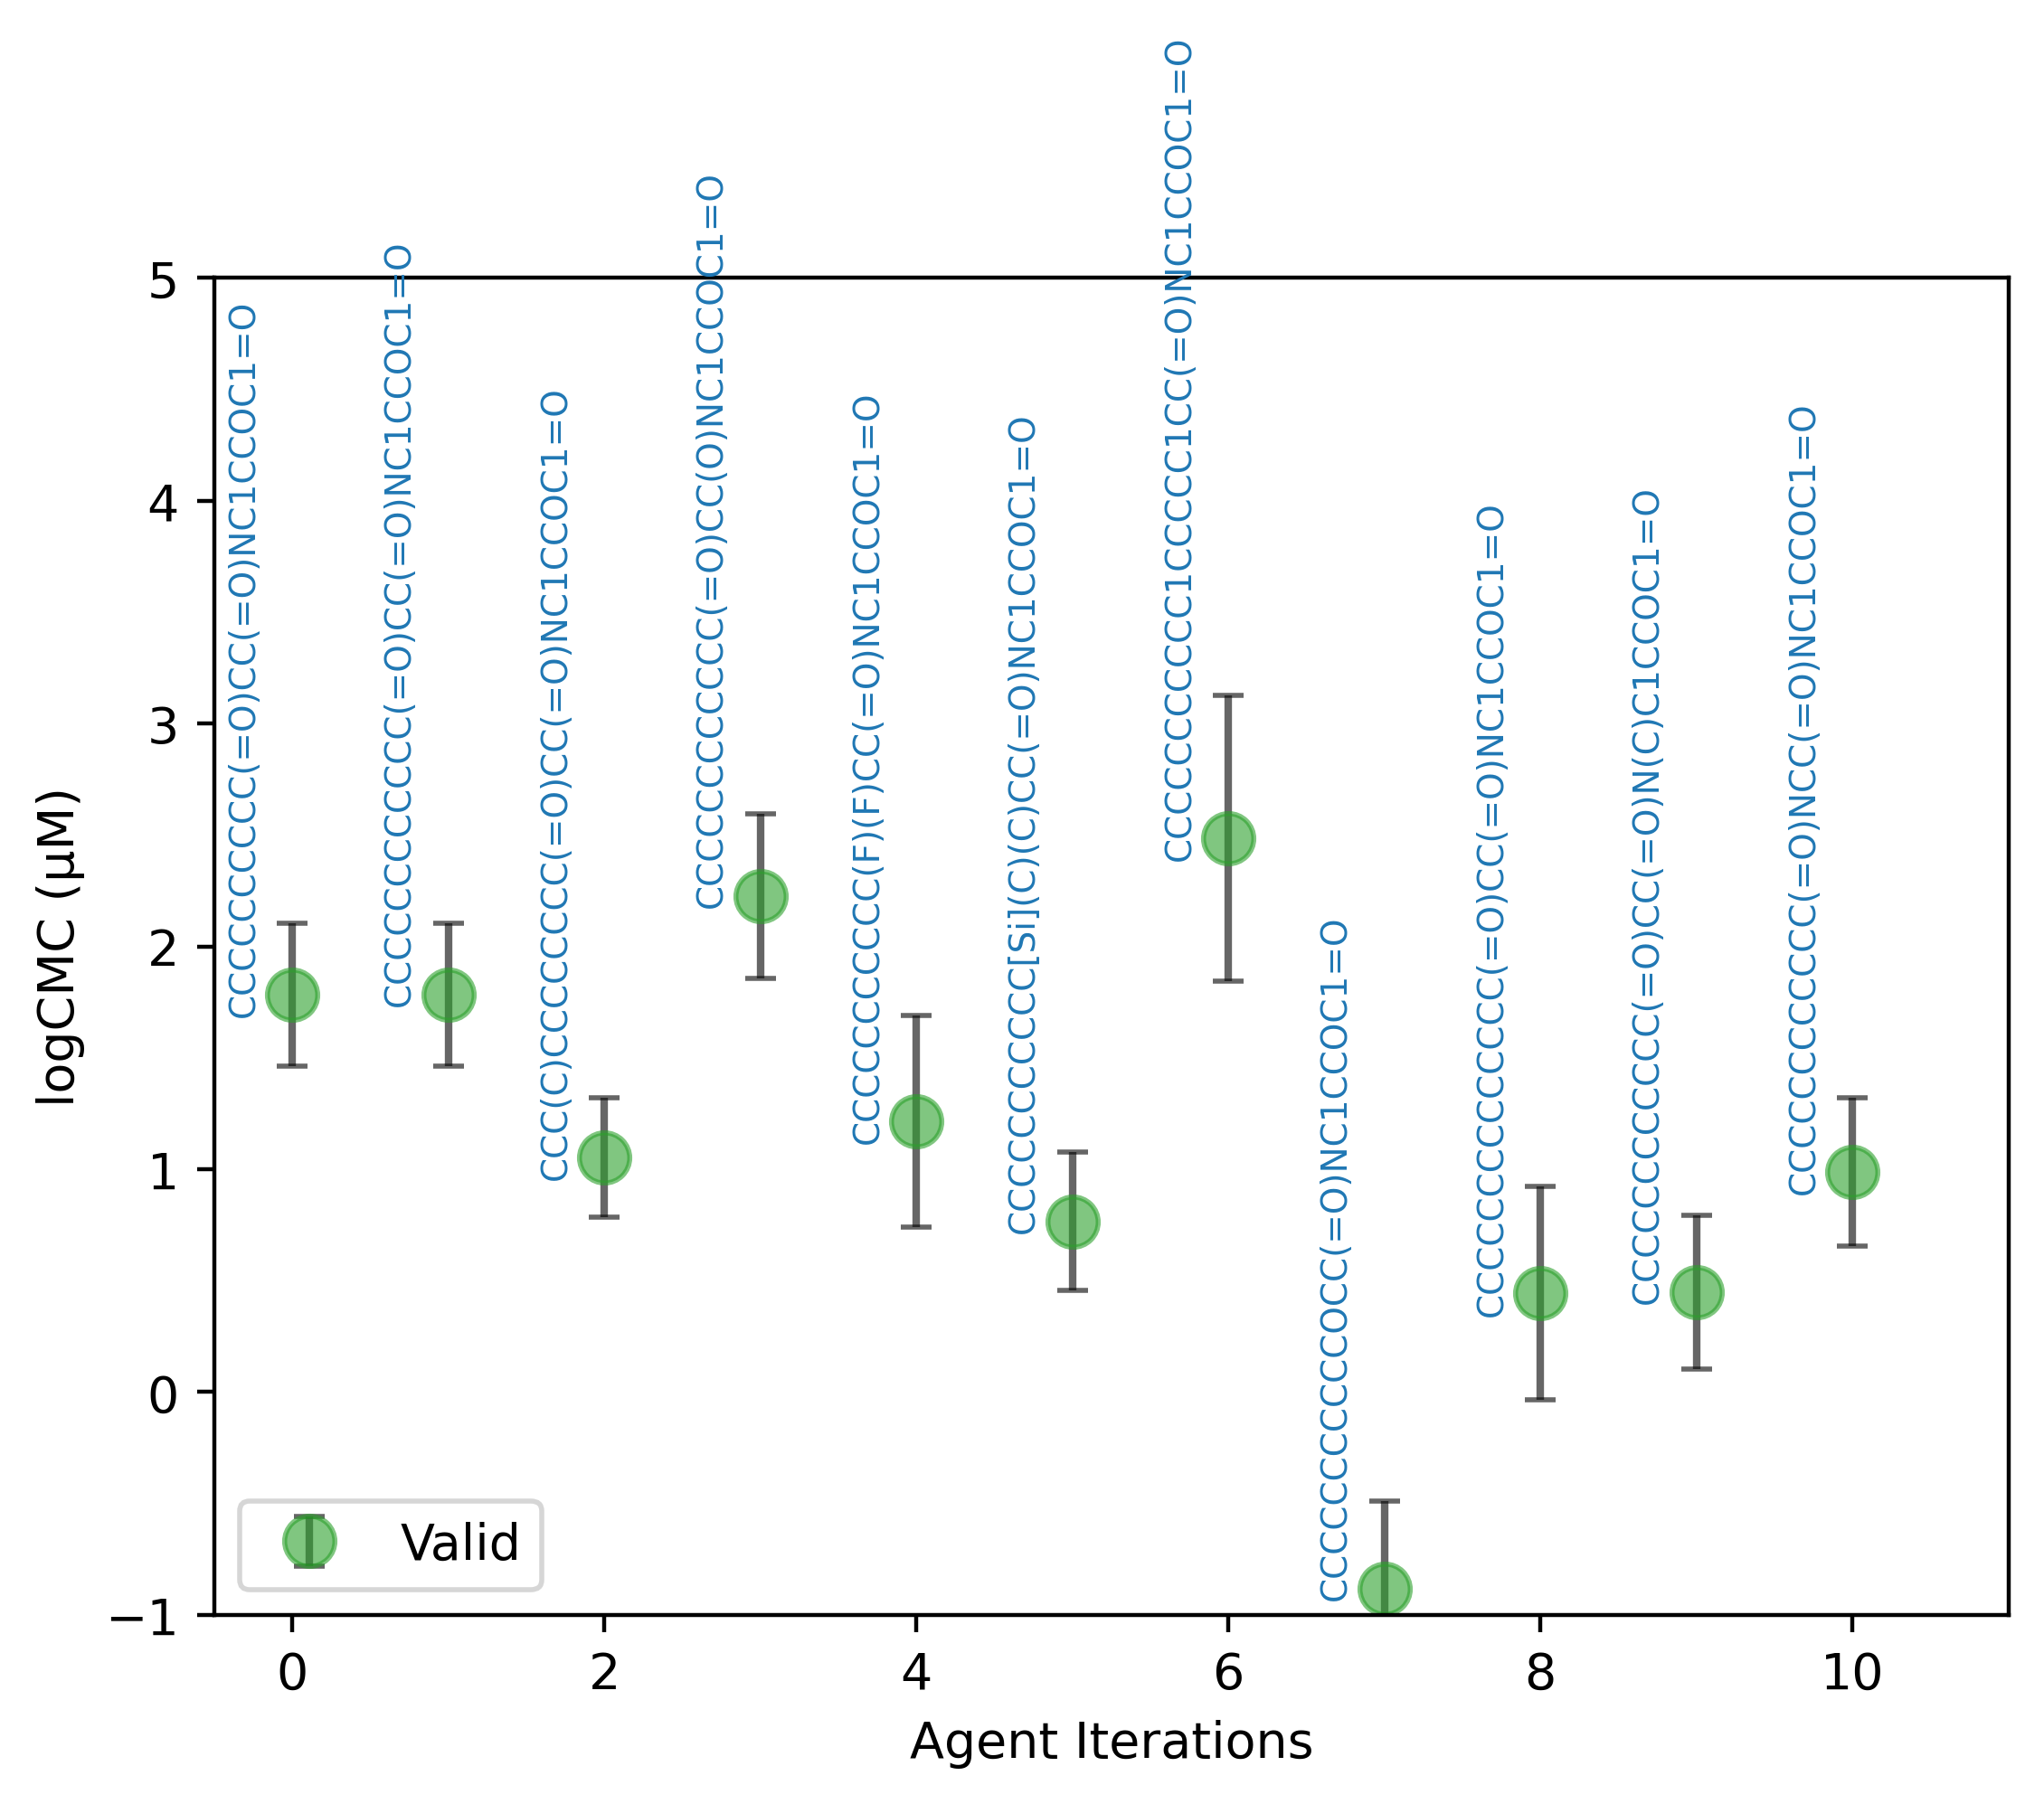

In [75]:
import matplotlib.pyplot as plt

iterations = [item['iteration'] for item in iteration_data]
mean_cmcs = [item['data']['mean CMC'] for item in iteration_data]
std_cmc = [item['data']['std CMC'] for item in iteration_data]
smiles_labels = [item['data']['SMILES'] for item in iteration_data]
chemical_feasibilities = [item['data']['Chemical Feasibility'] for item in iteration_data]

plt.figure(dpi=400)

colors = ['C2' if feas == 'Valid' else 'C0' for feas in chemical_feasibilities]

# Plot with error bars and color-coded points
plt.figure(dpi=400)
for i, (x, y, yerr, color) in enumerate(zip(iterations, mean_cmcs, std_cmc, colors)):
    plt.errorbar(x, y, yerr=yerr, fmt='o', color=color, ecolor='k', capsize=3,
                 linestyle='None', alpha=0.6, markersize=10, label=chemical_feasibilities[i])



vertical_offsets = [(-10 + 5 * (i % 2)) for i in range(len(iterations))]  # Alternating vertical offsets

for x, y, label, offset in zip(iterations, mean_cmcs, smiles_labels, vertical_offsets):
    plt.text(x-0.2, y + offset/100, label, verticalalignment='bottom', horizontalalignment='right', fontsize=7, color='C0', rotation=90)

ax=plt.gca()
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))

plt.legend(by_label.values(), by_label.keys(), loc="lower left")

plt.xlabel('Agent Iterations')
plt.xlim([-0.5,11])
plt.ylim([-1, 5])
plt.ylabel('logCMC (μM)')

plt.savefig(f"../results/{iteration_data[0]['data']['SMILES']}_guided.png")

<Figure size 2560x1920 with 0 Axes>

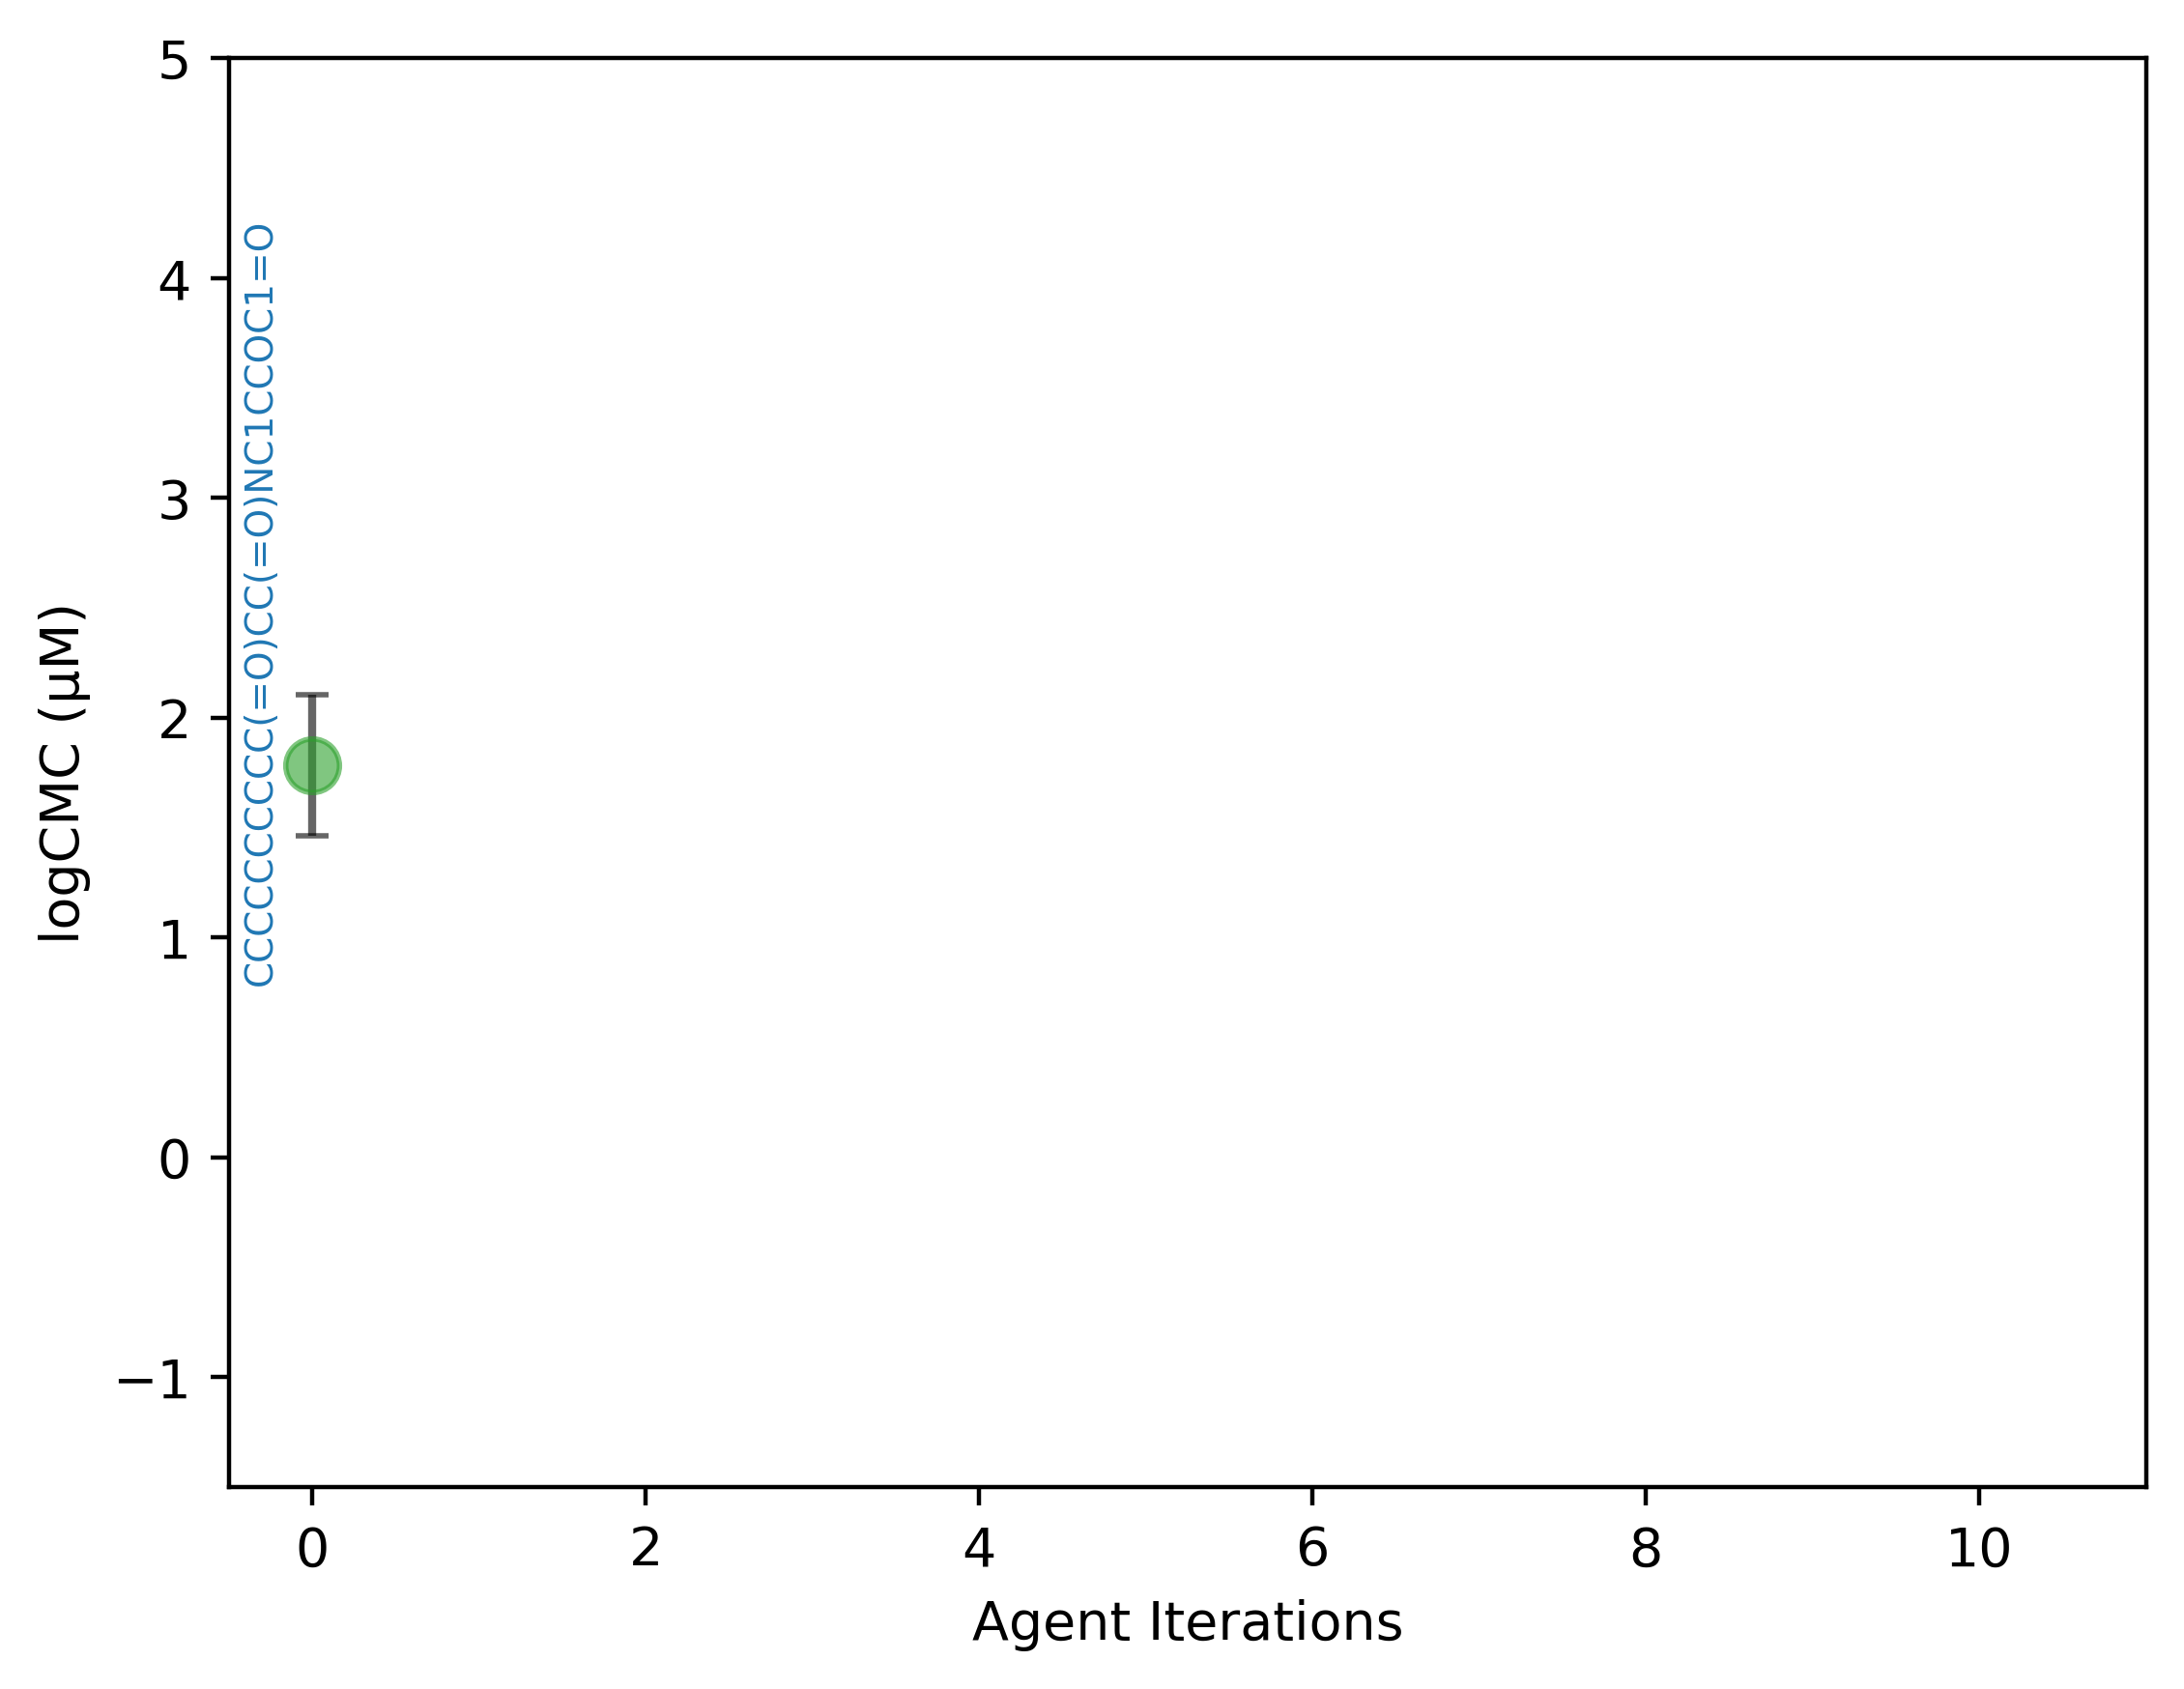

In [105]:
## Plotting sequntially for presentation purposes

from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
import numpy as np



from rdkit.Chem import Draw
from PIL import Image

def visualize_smiles(smiles, filename):
    # Convert SMILES to molecule
    mol = Chem.MolFromSmiles(smiles)
    
    # Generate image of the molecule with RDKit and a transparent background
    img = Draw.MolToImage(mol, size=(1000, 1000), kekulize=True, wedgeBonds=True, options=Draw.DrawingOptions())
    
    # Convert the image to have a transparent background
    img = img.convert("RGBA")
    datas = img.getdata()
    newData = []
    for item in datas:
        # Change all white (also shades of whites)
        # to transparent
        if item[0] > 200 and item[1] > 200 and item[2] > 200:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
    img.putdata(newData)
    
    # Save the image
    img.save(filename, "PNG")


import json

initial_surfactant = "CCCCCCCCCC(=O)CC(=O)NC1CCOC1=O" 

with open(f"../results/CMC/{initial_surfactant}_guided.json", "r") as json_file:
    iteration_data = json.load(json_file)

iterations = [item['iteration'] for item in iteration_data]
mean_cmcs = [item['data']['mean CMC'] for item in iteration_data]
std_cmcs = [item['data']['std CMC'] for item in iteration_data]
smiles_labels = [item['data']['SMILES'] for item in iteration_data]
chemical_feasibilities = [item['data']['Chemical Feasibility'] for item in iteration_data]

plt.figure(dpi=400)

colors = ['C2' if feas == 'Valid' else 'C0' for feas in chemical_feasibilities]

# Plot with error bars and color-coded points

iter = 0

plt.figure(dpi=400)
for i, (x, y, yerr, color) in enumerate(zip(iterations, mean_cmcs, std_cmcs, colors)):
    plt.errorbar(x, y, yerr=yerr, fmt='o', color=color, ecolor='k', capsize=3,
                 linestyle='None', alpha=0.6, markersize=10, label=chemical_feasibilities[i])

    filename = f'../results/CMC/iter_{i}_{smiles_labels[i]}.png'
    visualize_smiles(smiles_labels[i], filename)
    if i == iter:
        break


vertical_offsets = [(-10 + 5 * (k % 2)) for k in range(len(iterations))]  # Alternating vertical offsets

for i, (x, y, label, offset) in enumerate(zip(iterations, mean_cmcs, smiles_labels, vertical_offsets)):
    plt.text(x-0.2, y + offset/10, label, verticalalignment='bottom', horizontalalignment='right', fontsize=7, color='C0', rotation=90)
    if i == iter:
        break

ax=plt.gca()
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))

# plt.legend(by_label.values(), by_label.keys(), loc="lower left")

plt.xlabel('Agent Iterations')
plt.xlim([-0.5,11])
plt.ylim([-1.5, 5])
plt.ylabel('logCMC (μM)')

plt.savefig(f"../results/CMC/{iter}_{smiles_labels[iter]}_guided.png")

In [87]:
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt



from rdkit.Chem import Draw
from PIL import Image
from rdkit.Chem import Draw, rdDepictor

# Initialize the depiction settings
rdDepictor.SetPreferCoordGen(True)
options = Draw.DrawingOptions()
options.bondLineWidth = 2
options.fixedBondLength = 10

def visualize_smiles(smiles, filename):
    # Convert SMILES to molecule
    mol = Chem.MolFromSmiles(smiles)
    
    # Generate image of the molecule with RDKit and a transparent background
    img = Draw.MolToImage(mol, size=(1000, 1000), kekulize=True, wedgeBonds=True, options=options)
    
    # Convert the image to have a transparent background
    img = img.convert("RGBA")
    datas = img.getdata()
    newData = []
    for item in datas:
        # Change all white (also shades of whites)
        # to transparent
        if item[0] > 200 and item[1] > 200 and item[2] > 200:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
    img.putdata(newData)
    
    # Save the image
    img.save(filename, "PNG")

# Example usage
filename = f'{initial_surfactant}.png'
visualize_smiles(initial_surfactant, filename)

In [67]:
predict_cmc('CCCCCCCCCCCC(=O)CC(=O)NC1CCOC1=O')

(1.054, 0.268)